In [1]:
import sys
sys.path.append('../src/')

%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 10)

from scipy.integrate import simps
from benchmark.stats import calc_precision_recall, calc_ap

In [2]:
df = pd.read_csv('./results/mtcnn-20220406-175020.tsv', sep='\t', header=0, parse_dates=["Timestamp"])
df_ap = pd.read_csv('./results/mtcnn-20220406-175020-ap.tsv', sep='\t', header=0)
df_ap = df_ap.sort_values(by=['Confidence'], ignore_index=True, ascending=False)
df_load = pd.read_csv('./results/mtcnn-20220406-175020-load.tsv', sep='\t', header=0, parse_dates=["Timestamp"])
df_meta = pd.read_csv('./results/mtcnn-20220406-175020-metadata.tsv', sep='\t', header=0)

In [3]:
df_meta

,Python,CPU,GPUs
0,3.8.8.final.0 (64 bit),AMD Ryzen 7 2700X Eight-Core Processor,"['device: 0, name: NVIDIA GeForce GTX 1080 Ti,..."


In [4]:
df_load

,Timestamp,CPU_Load,RAM_Avail
0,2022-04-06 17:50:20.414823,5.2,3934912512
1,2022-04-06 17:50:31.576821,56.9,3273113600
2,2022-04-06 17:50:42.696322,46.3,3267940352
3,2022-04-06 17:50:53.783822,67.7,3225362432
4,2022-04-06 17:51:05.095323,64.2,3218219008
...,...,...,...
92,2022-04-06 18:07:42.125823,72.4,3431632896
93,2022-04-06 18:07:53.291823,73.4,3402903552
94,2022-04-06 18:08:04.430322,75.7,3395260416
95,2022-04-06 18:08:16.403322,72.6,3442929664


In [5]:
def plot_data_over_time(time, data, label):
    plt.plot(time, data)
    plt.xlabel('Time') 
    plt.ylabel(label)
    plt.grid(True)
    plt.show()

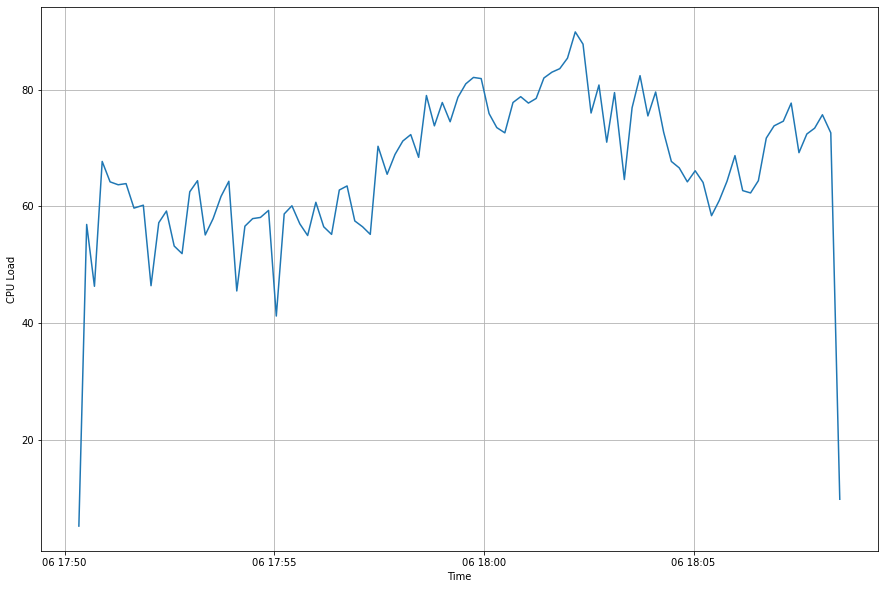

In [6]:
plot_data_over_time(df_load['Timestamp'], df_load['CPU_Load'], 'CPU Load')

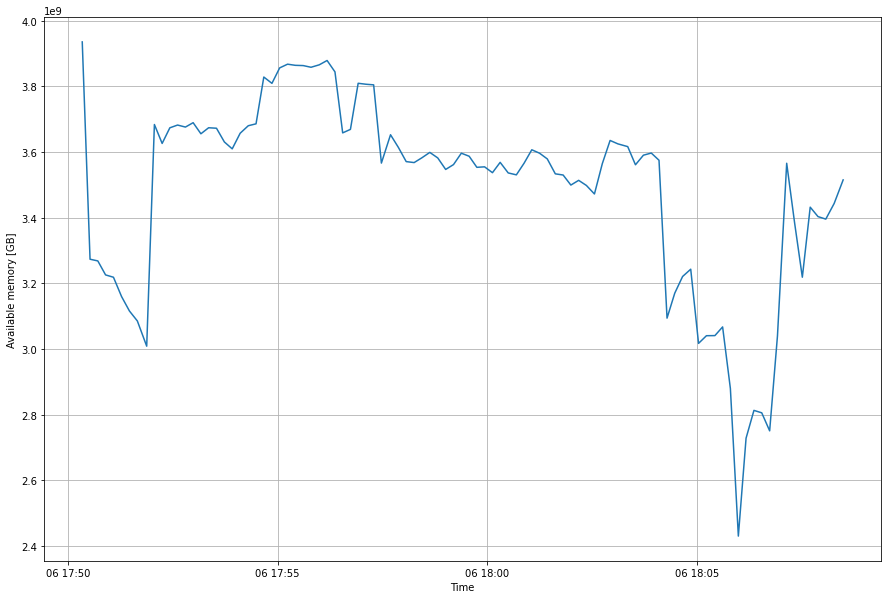

In [7]:
plot_data_over_time(df_load['Timestamp'], df_load['RAM_Avail'], 'Available memory [GB]')

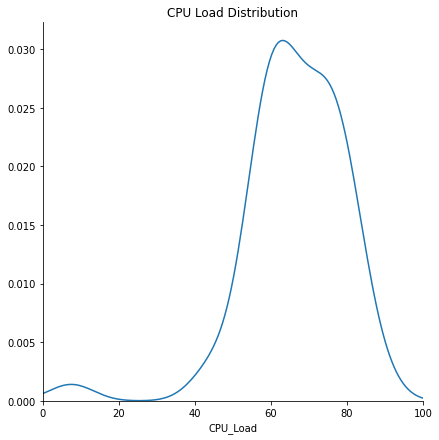

In [8]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'CPU_Load').add_legend()
plt.title('CPU Load Distribution')
plt.xlim(0, 100)
plt.show()

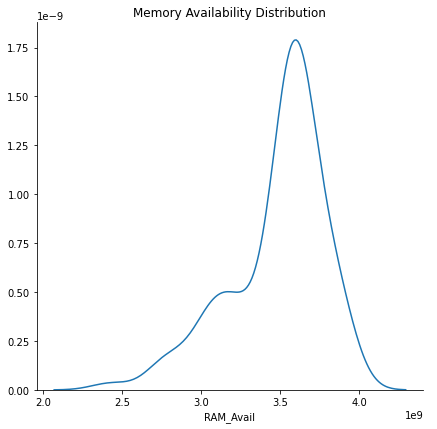

In [9]:
sns.FacetGrid(df_load, height=6).map(sns.kdeplot, 'RAM_Avail').add_legend()
plt.title('Memory Availability Distribution')
plt.show()

In [10]:
df

,Timestamp,Speed,Precision,Recall,F1_Score,Ious,Positives,False_Positives,Negatives,Num_Of_Faces,Predicted,Ground_Truth
0,2022-04-06 17:50:21.128322,281269100,1.000000,1.000000,1.000000,"[0.8915242805755396, 0.8778703002775675, 0.771...",8,0,0,8,"[(176.0, 141.0, 255.0, 245.0), (785.0, 190.0, ...","[(909.0, 335.0, 974.0, 418.0), (786.0, 187.0, ..."
1,2022-04-06 17:50:21.405324,271668300,0.000000,0.000000,0.000000,[],0,0,1,1,[],"[(547.0, 1228.0, 688.0, 1333.0)]"
2,2022-04-06 17:50:21.662322,249158900,1.000000,1.000000,1.000000,"[0.8058647841433614, 0.8445652173913043]",2,0,0,2,"[(551.0, 117.0, 604.0, 174.0), (459.0, 48.0, 4...","[(459.0, 45.0, 499.0, 91.0), (551.0, 107.0, 60..."
3,2022-04-06 17:50:22.001323,215650600,1.000000,0.112903,0.202899,"[0.8086548488008342, 0.7382198952879581, 0.830...",7,0,55,62,"[(61.0, 494.0, 99.0, 541.0), (254.0, 496.0, 29...","[(82.0, 278.0, 90.0, 287.0), (96.0, 272.0, 106..."
4,2022-04-06 17:50:22.283822,262914000,1.000000,1.000000,1.000000,"[0.8859470468431772, 0.8551800965466023, 0.807...",8,0,0,8,"[(268.0, 70.0, 317.0, 128.0), (410.0, 89.0, 45...","[(104.0, 77.0, 152.0, 135.0), (199.0, 78.0, 24..."
...,...,...,...,...,...,...,...,...,...,...,...,...
3221,2022-04-06 18:08:17.918324,356544000,1.000000,1.000000,1.000000,[0.7898197662903546],1,0,0,1,"[(457.0, 159.0, 584.0, 316.0)]","[(452.0, 146.0, 587.0, 333.0)]"
3222,2022-04-06 18:08:18.398822,472475400,1.000000,1.000000,1.000000,"[0.767156406918356, 0.7021690767519466]",2,0,0,2,"[(715.0, 421.0, 797.0, 531.0), (331.0, 415.0, ...","[(324.0, 408.0, 417.0, 524.0), (712.0, 408.0, ..."
3223,2022-04-06 18:08:18.833322,352359800,0.964286,1.000000,0.981818,"[0.8267477203647416, 0.875, 0.8185483870967742...",27,1,0,27,"[(736.0, 501.0, 768.0, 540.0), (521.0, 479.0, ...","[(70.0, 307.0, 102.0, 343.0), (121.0, 301.0, 1..."
3224,2022-04-06 18:08:19.005822,152815300,1.000000,0.857143,0.923077,"[0.8199643493761141, 0.7321225879682179, 0.959...",6,0,1,7,"[(855.0, 82.0, 901.0, 142.0), (113.0, 109.0, 1...","[(451.0, 94.0, 478.0, 121.0), (394.0, 99.0, 40..."


In [11]:
df.describe()

,Speed,Precision,Recall,F1_Score,Positives,False_Positives,Negatives,Num_Of_Faces
count,3.226000e+03,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000,3226.000000
mean,2.928778e+08,0.818584,0.690175,0.709836,4.829820,0.459392,7.478921,12.308741
std,1.406316e+08,0.321229,0.370292,0.339619,10.732831,0.961133,33.861611,39.822258
min,7.037770e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.962783e+08,0.765837,0.400000,0.500000,1.000000,0.000000,0.000000,1.000000
50%,2.649750e+08,1.000000,0.954545,0.822479,2.000000,0.000000,1.000000,3.000000
75%,3.500883e+08,1.000000,1.000000,1.000000,5.000000,1.000000,4.000000,9.000000
max,1.924034e+09,1.000000,1.000000,1.000000,259.000000,13.000000,624.000000,709.000000


In [12]:
df_ap

,Confidence,TP_FP
0,1.000000,TP
1,1.000000,TP
2,1.000000,TP
3,1.000000,TP
4,1.000000,TP
...,...,...
17058,0.700543,FP
17059,0.700464,TP
17060,0.700239,TP
17061,0.700187,TP


In [49]:
all_gts = df['Positives'].sum() + df['Negatives'].sum()

df_ap = calc_precision_recall(df_ap, all_gts)

In [50]:
df_ap

,Confidence,TP_FP,Precision,Recall
0,1.000000,TP,1.000000,0.000025
1,1.000000,TP,1.000000,0.000050
2,1.000000,TP,1.000000,0.000076
3,1.000000,TP,1.000000,0.000101
4,1.000000,TP,1.000000,0.000126
...,...,...,...,...
17058,0.700543,FP,0.913125,0.392289
17059,0.700464,TP,0.913130,0.392314
17060,0.700239,TP,0.913135,0.392339
17061,0.700187,TP,0.913140,0.392364


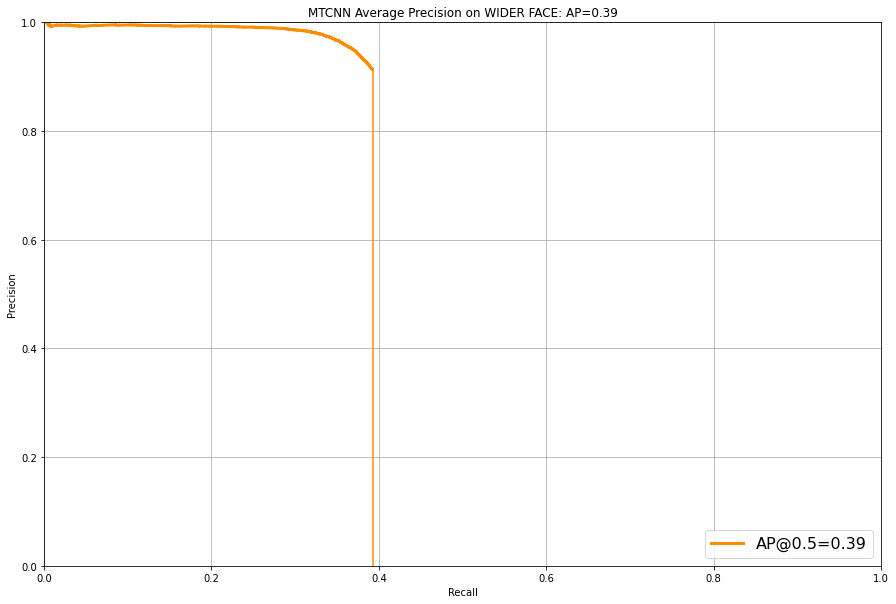

In [51]:
ap = calc_ap(df_ap)

plt.plot(df_ap['Recall'], df_ap['Precision'], color='darkorange', lw=3, label="AP@0.5=%.2f" % ap)
plt.axvline(x = df_ap['Recall'][df_ap.index[-1]], ymax=df_ap['Precision'][df_ap.index[-1]], color = "darkorange")
plt.xlim(0, 1.00)
plt.ylim(0, 1.00)

plt.title('MTCNN Average Precision on WIDER FACE: AP=%.2f' % ap)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right", prop={'size': 16})
plt.grid(True)

plt.show()